In [1]:
# import necessary modules
import tensorflow as tf
# %pylab inline
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from time import time

# prepare the data, using one-hot representation for labels
def prepare_data():
    data = pd.read_csv('train.csv')
    data = np.array(data)
    X = data[:,1:] / 255 # division by 255 is to normalize pixel intensities
    y = data[:,0]
    # transform y to be one-hot
    n = len(y)
    y_one_hot = np.zeros((n,10),dtype=int)
    for i in range(n):
        y_one_hot[i,int(y[i])] = 1

    # split into train and test datasets
    split = n//3*2
    X_train = X[:split,:]
    y_train = y_one_hot[:split,:]
    
    X_validate = X[split:,:]
    y_validate = y_one_hot[split:,:]
    train = [X_train,y_train]
    validate = [X_validate,y_validate]
    return [train,validate]

train,validate = prepare_data()

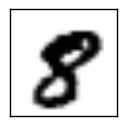

In [2]:
# test interpretation of data
test = train[0][10,:].reshape(28,28)
fig = plt.figure(figsize=(8, 8))
for i in range(1):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(test, cmap=plt.cm.binary)

In [3]:
# some functions to streamline description of tensor graph

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='VALID')

# describe the flow of the graph
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    x_image = tf.reshape(x, [-1,28,28,1])
    
    # first convo
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    # second convo
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2) # shape [50,4,4,64]
    
    # first fully connected layer
    W_fc1 = weight_variable([4 * 4 * 64, 30])
    b_fc1 = bias_variable([30])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 4*4*64]) # shape [50,4*4*64] like a flattened image
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    # dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    # second and final fully connected layer
    W_fc2 = weight_variable([30, 10])
    b_fc2 = bias_variable([10])
    y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    
    # cost function
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
    
    # optimization method
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
    # validation
    prediction = tf.argmax(y_conv,1)
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()

In [4]:
with tf.Session(graph=graph) as session:
    init.run()
    # saver.restore(session, "model_relu.ckpt")
    test_accuracy_prev = 0
    iterations = 100
    batch_size = 10
    n = len(train[0])
    mini_batches = [[train[0][k*batch_size:(k+1)*batch_size,:],
                     train[1][k*batch_size:(k+1)*batch_size,:]] 
                     for k in range(0,n//batch_size)]
    for i in range(iterations):
        time_0 = time()
        for mini_batch in mini_batches:
            train_step.run(feed_dict = {x:mini_batch[0],y_:mini_batch[1],keep_prob: 0.5})
        train_accuracy = accuracy.eval(feed_dict={x:mini_batch[0], y_: mini_batch[1], keep_prob: 1.0})
        test_accuracy = accuracy.eval(feed_dict={x: validate[0], y_: validate[1], keep_prob: 1.0})
        print("step {0}, training accuracy {1}, test accuracy {2}".format(i, train_accuracy, test_accuracy))
        if test_accuracy >= test_accuracy_prev:
            test_accuracy_prev = test_accuracy
            save_path = saver.save(session, "model_relu.ckpt")
            print("Model saved in file: {0}".format(save_path))
        else: break

step 0, training accuracy 0.699999988079071, test accuracy 0.9356428384780884
Model saved in file: model_relu.ckpt
step 1, training accuracy 0.800000011920929, test accuracy 0.9567142724990845
Model saved in file: model_relu.ckpt
step 2, training accuracy 0.8999999761581421, test accuracy 0.9649999737739563
Model saved in file: model_relu.ckpt
step 3, training accuracy 0.8999999761581421, test accuracy 0.9679285883903503
Model saved in file: model_relu.ckpt
step 4, training accuracy 1.0, test accuracy 0.9720714092254639
Model saved in file: model_relu.ckpt
step 5, training accuracy 1.0, test accuracy 0.9727857112884521
Model saved in file: model_relu.ckpt
step 6, training accuracy 0.8999999761581421, test accuracy 0.9734285473823547
Model saved in file: model_relu.ckpt
step 7, training accuracy 1.0, test accuracy 0.9756428599357605
Model saved in file: model_relu.ckpt
step 8, training accuracy 1.0, test accuracy 0.9779285788536072
Model saved in file: model_relu.ckpt
step 9, training a